In [1]:
from typing import Literal

import numpy as np
import numpy.typing as npt
from matplotlib import pyplot as plt
import seaborn as sns
from matplotlib.widgets import Slider
%matplotlib widget

In [2]:
class GridWorld:
    """"""

    def __init__(self, discount_factor: float = 0.9) -> None:
        """
        Constructor
        :param discount_factor: Gamma factor
        """
        self.discount_factor = discount_factor
        self.directions: list[str] = ['N', 'E', 'S', 'W']
        self.state_values: npt.NDArray = np.zeros((5, 5))
        self.list_of_state_values =[np.zeros((5, 5))]

        self.pos: npt.NDArray = np.random.randint(0, 5, size=(1, 2))[0]

        self.A: npt.NDArray = np.array([0, 1])
        self.A_prime: npt.NDArray = np.array([4, 1])
        self.B_prime: npt.NDArray = np.array([2, 3])
        self.B: npt.NDArray = np.array([0, 3])
        
        # init action matrices
        self.N_mat: npt.NDArray = np.zeros((5, 5))
        self.E_mat: npt.NDArray = np.zeros((5, 5))
        self.S_mat: npt.NDArray = np.zeros((5, 5))
        self.W_mat: npt.NDArray = np.zeros((5, 5))
        
        #init corresponding lists of matrices
        self.N_list = [np.zeros((5, 5))]
        self.E_list = [np.zeros((5, 5))]
        self.S_list = [np.zeros((5, 5))]
        self.W_list = [np.zeros((5, 5))]

    def _policy(self) -> str:
        """
        The Agent's policy
        :return: Direction of movement
        """
        return np.random.choice(self.directions)

    def _reward(self, direction: Literal['N', 'E', 'S', 'W'] | str) -> int:
        """
        Return the reward of the agent based on its position.
        :param direction: Direction the agent is going to move. 
        :return: Reward
        """
        # check if new position is at A or B
        if np.array_equal(self.pos, self.A):
            return 10
        elif np.array_equal(self.pos, self.B):
            return 5
        new_pos: npt.NDArray = self.pos.copy()
        # if going up
        if direction == 'N':
            new_pos = np.add(new_pos, np.array([-1, 0]))
        # if going left
        elif direction == 'W':
            new_pos = np.add(new_pos, np.array([0, -1]))
        # if going down
        elif direction == 'S':
            new_pos = np.add(new_pos, np.array([1, 0]))
        # if going right
        elif direction == 'E':
            new_pos = np.add(new_pos, np.array([0, 1]))
        else:
            raise ValueError("Invalid direction: {}".format(direction))

        # check if new position is in grid
        if not ((0 <= new_pos[0] <= 4) and (0 <= new_pos[1] <= 4)):
            # penalty
            return -1
        return 0
    
    def _move(self, direction: Literal['N', 'E', 'S', 'W'] | str) -> npt.NDArray:
        """
        Return the agent's position when moving in one of the four direction.
        :param direction: Direction of movement 
        :return: The agent's new position.
        """
        if np.array_equal(self.pos, self.A):
            return self.A_prime
        elif np.array_equal(self.pos, self.B):
            return self.B_prime
        new_pos: npt.NDArray = self.pos.copy()
        # if going up
        if direction == 'N':
            new_pos = np.add(new_pos, np.array([-1, 0]))
        # if going left
        elif direction == 'W':
            new_pos = np.add(new_pos, np.array([0, -1]))
        # if going down
        elif direction == 'S':
            new_pos = np.add(new_pos, np.array([1, 0]))
        # if going right
        elif direction == 'E':
            new_pos = np.add(new_pos, np.array([0, 1]))
        else:
            raise ValueError("Invalid direction: {}".format(direction))
        # check if new position is in grid
        if (0 <= new_pos[0] <= 4) and (0 <= new_pos[1] <= 4):
            # return position
            return new_pos
        # otherwise the agent should stay in grid
        return self.pos

    def bellman_state_value_function(self, runs: int = 10000) -> None:
        """
        State-Value-Function using the Bellman expectation.
        :param runs: Number of steps the agent is going to do per episode.
        :return: None
        """
        for _ in range(runs):
            old_pos = self.pos.copy()
            new_state_value: float = 0.0
            for action in self.directions:
                # get reward
                reward = self._reward(direction=action)
                new_pos = self._move(direction=action)
                # get next state
                new_state_value += (reward + self.discount_factor * self.state_values[*new_pos]) / 4
            # update state value (and list)
            self.state_values[*old_pos] = new_state_value
            self.list_of_state_values.append(self.state_values.copy())
            # update position
            self.pos = self._move(direction=self._policy())
            
    def bellman_action_value_function(self, runs: int = 10000) -> None:
        """
        Action-Value-Function using the Bellman expectation.
        :param runs: Number of steps the agent is going to do per episode.
        :return: None
        """
        for _ in range(runs):
            old_pos = self.pos.copy()
            for action in self.directions:
                # get reward
                reward = self._reward(direction=action)
                new_pos = self._move(direction=action)
                # get next state
                new_action_value = reward + self.discount_factor * (
                        self.N_mat[*new_pos] + self.E_mat[*new_pos] + self.S_mat[*new_pos] + self.W_mat[*new_pos]) / 4
                # update corresponding direction matrix
                if action == 'N':
                    self.N_mat[*old_pos] = new_action_value
                elif action == 'E':
                    self.E_mat[*old_pos] = new_action_value
                elif action == 'S':
                    self.S_mat[*old_pos] = new_action_value
                elif action == 'W':
                    self.W_mat[*old_pos] = new_action_value
            # update position
            self.pos = self._move(direction=self._policy())


In [3]:
env = GridWorld()

RUNS = 10000
env.bellman_state_value_function(runs=RUNS)

In [4]:
env.state_values

array([[ 3.30899634,  8.78929186,  4.42761918,  5.32236759,  1.49217876],
       [ 1.52158807,  2.99231786,  2.25013995,  1.9075717 ,  0.54740271],
       [ 0.05082249,  0.73817059,  0.67311326,  0.35818621, -0.40314114],
       [-0.9735923 , -0.43549543, -0.35488227, -0.58560509, -1.18307508],
       [-1.85770055, -1.34523126, -1.22926726, -1.42291815, -1.97517905]])

In [7]:
# This function takes a list of matrices (lom) and then plots it into a changeable heatmap
def grafik(lom):
    # Create the initial heatmap
    fig, ax = plt.subplots()
    heatmap = sns.heatmap(lom[0], vmin=-2, vmax=10, ax=ax, cbar=True, annot=True, cmap='rocket_r')

    # Adjust the main plot to make room for the slider
    plt.subplots_adjust(left=0.25, bottom=0.25)

    # Define the slider axis and create the slider
    ax_slider = plt.axes([0.25, 0.1, 0.65, 0.03])
    slider = Slider(ax_slider, 'Iterations: ', 0, len(lom) - 1, valinit=0, valstep=100)

    # Update function to update the heatmap when the slider is moved
    def update(val):
        index = int(slider.val)
        ax.clear()
        sns.heatmap(lom[index], ax=ax, cbar=False, annot=True, cmap='rocket_r')
        fig.canvas.draw_idle()

    # Add an action to update the slider
    slider.on_changed(update)
    plt.plot()

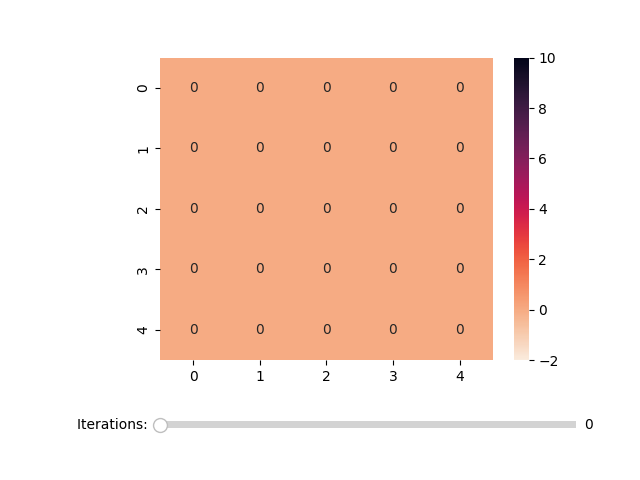

In [9]:
grafik(env.list_of_state_values)

Beschreibung der Ergebnisse der Berechnungen:
Als Ergebnis erhalten wir eine 5x5 Matrix, die vom Aufbau mit unserer Grid-World Umgebung übereinstimmt. Dabei gibt der Wert (i,j) in der state_value Matrix, den state_value der Position (i,j) in der Grid-World an. Dieser gibt an, wie "gut" es ist, dass wir uns auf diesem Feld befinden. Ist der Wert negativ, so ist bei zufälligem Verhalten in näherer Zukunft ein negativer Reward zu erwarten. Ist der Wert positiv (z.B. an Position A), so können wir mit einem positiven Reward in Zukunft rechnen.
Der Vorteil, den die Verwendung einer zufälligen Policy mit sich bringt, ist, dass genügend Informationen über alle Felder gesammelt werden. Eine Return-orientierte Policy hätte das Problem, dass vorrangig Informationen über "gute" Felder gesammelt werden. Dies führt zu einem ähnlichen Problem, wie bei den Multi-arm-Bandits, i.e. eine gute Alternative, wie Weg B wird evtl. nicht gefunden.

In [40]:
env = GridWorld(discount_factor=0.3)
env.bellman_action_value_function(runs=RUNS)

In [41]:
grafik(env.N_list)

array([[-9.20246523e-01,  9.89376302e+00, -7.15030340e-01,
         4.99999442e+00, -1.05154661e+00],
       [ 7.97534767e-02,  2.96812891e+00,  2.84969660e-01,
         1.49999833e+00, -5.15466128e-02],
       [-6.42561711e-02,  2.21925778e-01,  4.64985712e-02,
         1.09672353e-01, -8.41932715e-02],
       [-9.41720308e-02,  8.63906029e-03,  3.41315840e-03,
        -5.57950934e-06, -9.65094227e-02],
       [-1.05837936e-01, -1.59794346e-02, -9.62327329e-03,
        -1.66504826e-02, -1.06084029e-01]])

In [32]:
grafik(env.S_list)

array([[-6.42561711e-02,  9.89376302e+00,  4.64985712e-02,
         4.99999442e+00, -8.41932715e-02],
       [-9.41720308e-02,  8.63906029e-03,  3.41315840e-03,
        -5.57950934e-06, -9.65094227e-02],
       [-1.05837936e-01, -1.59794346e-02, -9.62327329e-03,
        -1.66504826e-02, -1.06084029e-01],
       [-1.95183081e-01, -1.06236978e-01, -9.90935517e-02,
        -1.06293553e-01, -1.95209787e-01],
       [-1.19518308e+00, -1.10623698e+00, -1.09909355e+00,
        -1.10629355e+00, -1.19520979e+00]])

In [33]:
grafik(env.W_list)

array([[-9.20246523e-01,  9.89376302e+00,  2.96812891e+00,
         4.99999442e+00,  1.49999833e+00],
       [-1.06425617e+00, -6.42561711e-02,  2.21925778e-01,
         4.64985712e-02,  1.09672353e-01],
       [-1.09417203e+00, -9.41720308e-02,  8.63906029e-03,
         3.41315840e-03, -5.57950934e-06],
       [-1.10583794e+00, -1.05837936e-01, -1.59794346e-02,
        -9.62327329e-03, -1.66504826e-02],
       [-1.19518308e+00, -1.95183081e-01, -1.06236978e-01,
        -9.90935517e-02, -1.06293553e-01]])

In [34]:
grafik(env.E_list)

array([[ 2.96812891e+00,  9.89376302e+00,  1.49999833e+00,
         4.99999442e+00, -1.05154661e+00],
       [ 2.21925778e-01,  4.64985712e-02,  1.09672353e-01,
        -8.41932715e-02, -1.08419327e+00],
       [ 8.63906029e-03,  3.41315840e-03, -5.57950934e-06,
        -9.65094227e-02, -1.09650942e+00],
       [-1.59794346e-02, -9.62327329e-03, -1.66504826e-02,
        -1.06084029e-01, -1.10608403e+00],
       [-1.06236978e-01, -9.90935517e-02, -1.06293553e-01,
        -1.95209787e-01, -1.19520979e+00]])

Als Ergebnis der Action-Value-Funktion erhalten wir in Abhängigkeit der Aktion eine Matrix. Dabei beschreibt der Wert in der Matrix zur Aktion a in dem jeweiligen Feld, wie "gut" das Feld ist. Dies ist so zu interpretieren, dass umso höher der Wert, umso sinnvoller ist es die jeweilige Aktion auszuführen, wenn man sich auf dem Feld befindet.
Die state-value Werte zeigen also an, wie hoch das Feld bei einer zufälligen Aktion zu bewerten ist, die Action-Value Werte beschreiben, wie hoch die Aktion zu bewerten ist, wenn man in dem jeweiligen Feld steht.
Dabei gibt jeder value eine Bewertung für das jeweilige Feld ab, einmal bezüglich einer zufälligen Aktion, einmal in Abhängigkeit von dieser.